In [193]:
import os
import inflect
import nltk
import re, string, unicodedata
import pandas as pd
import numpy as np
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from wordcloud import WordCloud
from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

from official.nlp import optimization  # to create AdamW optmizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

tf.get_logger().setLevel('ERROR')

In [91]:
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import (
    ColumnDataSource, GMapOptions, LinearColorMapper,
    FactorRange, ColorBar, BasicTicker, PrintfTickFormatter
)
from bokeh.palettes import Spectral3, Spectral6, Spectral7
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.plotting import gmap
from bokeh.layouts import gridplot, row

output_notebook() 

Loading BokehJS ...

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'

In [3]:
df_train_src = pd.read_csv('Corona_NLP_train.csv', index_col='UserName')
df_test_src = pd.read_csv('Corona_NLP_test.csv', index_col='UserName')

In [76]:
df_train_src.shape, df_test_src.shape

((41157, 5), (3798, 5))

In [79]:
df = pd.concat([df_train_src, df_test_src], copy=True, sort=False, axis=0)
df.drop(['ScreenName', 'TweetAt', 'Location'], axis=1, inplace=True)
df

,OriginalTweet,Sentiment
UserName,,
3799,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,advice Talk to your neighbours family to excha...,Positive
3801,Coronavirus Australia: Woolworths to give elde...,Positive
3802,My food stock is not the only one which is emp...,Positive
3803,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3794,Meanwhile In A Supermarket in Israel -- People...,Positive
3795,Did you panic buy a lot of non-perishable item...,Negative
3796,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral


In [101]:
label_vc = df['Sentiment'].value_counts()

source = ColumnDataSource(
    data=dict(labels=label_vc.index, counts=label_vc.values))

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
COLORS5 = ['#3CAEA3', '#ED553B', '#F6D55C', '#173F5F', '#20639B']
p = figure(
    tools=TOOLS,
    toolbar_location='above',
    x_range=df['Sentiment'].unique(),
    plot_height=350, title="Sentiment")

p.vbar(x='labels', top='counts', width=0.9, source=source,
       line_color='white', 
       fill_color=factor_cmap('labels', palette=COLORS5, factors=label_vc.index))

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.y_range.end = label_vc.max()

show(p)

In [100]:
df.loc[df['Sentiment']=='Extremely Positive', 'Sentiment'] = 'Positive'
df.loc[df['Sentiment']=='Extremely Negative', 'Sentiment'] = 'Negative'

In [107]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)
df['Tweet'] = df['OriginalTweet'].apply(lambda x: p.clean(x))

In [138]:
text = ' '.join(df['Tweet'].astype(str).str.lower().tolist())
wc = WordCloud().generate_from_text(text)

def generate_basic_wordcloud(data):
    cloud = WordCloud(width=600,
                      height=480,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stopwords.words('english'),
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(15,12))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
    

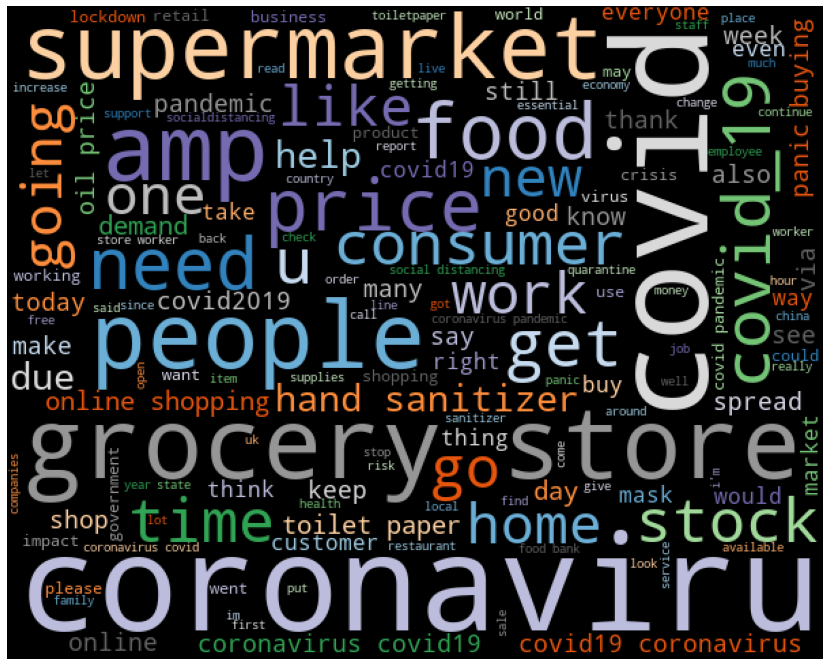

In [139]:
generate_basic_wordcloud(text)

In [37]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=5000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)


In [11]:
df_train = df.loc[df_train_src.index][['Tweet', 'Sentiment']]
df_test = df.loc[df_test_src.index][['Tweet', 'Sentiment']]

In [12]:
train, valid = train_test_split(
    df_train,
    train_size=0.7,
    random_state=0,
    stratify=df_train['Sentiment'])

y_train, X_train = \
    train['Sentiment'], train.drop(['Sentiment'], axis=1)
y_valid, X_valid = \
    valid['Sentiment'], valid.drop(['Sentiment'], axis=1)


# CatBoost model

In [ ]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['Tweet']
)

valid_pool = Pool(
    data=X_valid, 
    label=y_valid,
    text_features=['Tweet']
)

test_pool = Pool(
    data=df_test[[c for c in df_test.columns if c!='Sentiment']][['Tweet']], 
    label=df_test['Sentiment'],
    text_features=['Tweet']
)

In [50]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5145267	test: 0.5157110	best: 0.5157110 (0)	total: 21.1ms	remaining: 1m 45s
100:	learn: 0.7768753	test: 0.7602851	best: 0.7602851 (100)	total: 1.01s	remaining: 49.1s
200:	learn: 0.8162380	test: 0.7904114	best: 0.7904114 (200)	total: 1.9s	remaining: 45.4s
300:	learn: 0.8342879	test: 0.8019922	best: 0.8020732 (299)	total: 2.78s	remaining: 43.4s
400:	learn: 0.8501857	test: 0.8109006	best: 0.8109815 (399)	total: 3.66s	remaining: 42s
500:	learn: 0.8579958	test: 0.8136540	best: 0.8144639 (495)	total: 4.56s	remaining: 41s
600:	learn: 0.8655976	test: 0.8181892	best: 0.8181892 (600)	total: 5.45s	remaining: 39.9s
700:	learn: 0.8706307	test: 0.8194040	best: 0.8201328 (631)	total: 6.34s	remaining: 38.9s
800:	learn: 0.8764275	test: 0.8232102	best: 0.8232102 (800)	total: 7.23s	remaining: 37.9s
900:	learn: 0.8815301	test: 0.8253158	best: 0.8253158 (899)	total: 8.12s	remaining: 37s
1000:	learn: 0.8857649	test: 0.8275834	best: 0.8275834 (996)	total: 9.02s	remaining: 36s
1100:	learn: 0.88947

In [63]:
#bestTest = 0.8211046323
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
df_test['predict'] = model.predict(test_pool)

In [186]:
acc = model.score(test_pool)
print(f"CatBoost model accuracy: {acc}")
#0.8299104791995787

CatBoost model accuracy: 0.8299104791995787


In [160]:
y_true = df_test['Sentiment'].astype('category').cat.codes.values

<AxesSubplot:>

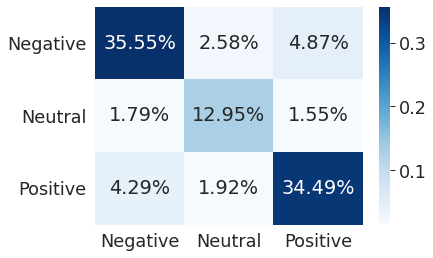

In [187]:
cf_matrix = get_confusion_matrix(model, test_pool)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [188]:
print('\nClassification Report For Catboost')
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(
    df_test['Sentiment'].astype('category').cat.codes.values,
    y_pred, target_names=target_names))


Classification Report For Catboost
              precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      1633
     Neutral       0.74      0.79      0.77       619
    Positive       0.84      0.85      0.85      1546

    accuracy                           0.83      3798
   macro avg       0.81      0.82      0.82      3798
weighted avg       0.83      0.83      0.83      3798



In [58]:
model.save_model(f"cb_model_{round(acc,4)}.cbm", format="cbm")

# BERT base-line model

In [141]:
tfhub_handle_encoder = \
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [142]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(
        shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [154]:
classifier_model = build_classifier_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [144]:
y_train_c = tf.keras.utils.to_categorical(
    y_train.astype('category').cat.codes.values, num_classes=3)
y_valid_c = tf.keras.utils.to_categorical(
    y_valid.astype('category').cat.codes.values, num_classes=3)

In [158]:
history = classifier_model.fit(
    x=X_train['Tweet'].values,
    y=y_train_c,
    validation_data=(X_valid['Tweet'].values, y_valid_c),
    epochs=5)

Epoch 1/5
901/901 [==============================] - 1107s 1s/step - loss: 0.7555 - accuracy: 0.6661 - val_loss: 0.5084 - val_accuracy: 0.8036
Epoch 2/5
901/901 [==============================] - 1096s 1s/step - loss: 0.4903 - accuracy: 0.8125 - val_loss: 0.4962 - val_accuracy: 0.8098
Epoch 3/5
901/901 [==============================] - 1094s 1s/step - loss: 0.4394 - accuracy: 0.8358 - val_loss: 0.4558 - val_accuracy: 0.8309
Epoch 4/5
901/901 [==============================] - 1088s 1s/step - loss: 0.4258 - accuracy: 0.8439 - val_loss: 0.4604 - val_accuracy: 0.8282
Epoch 5/5
901/901 [==============================] - 1086s 1s/step - loss: 0.4085 - accuracy: 0.8514 - val_loss: 0.4456 - val_accuracy: 0.8358


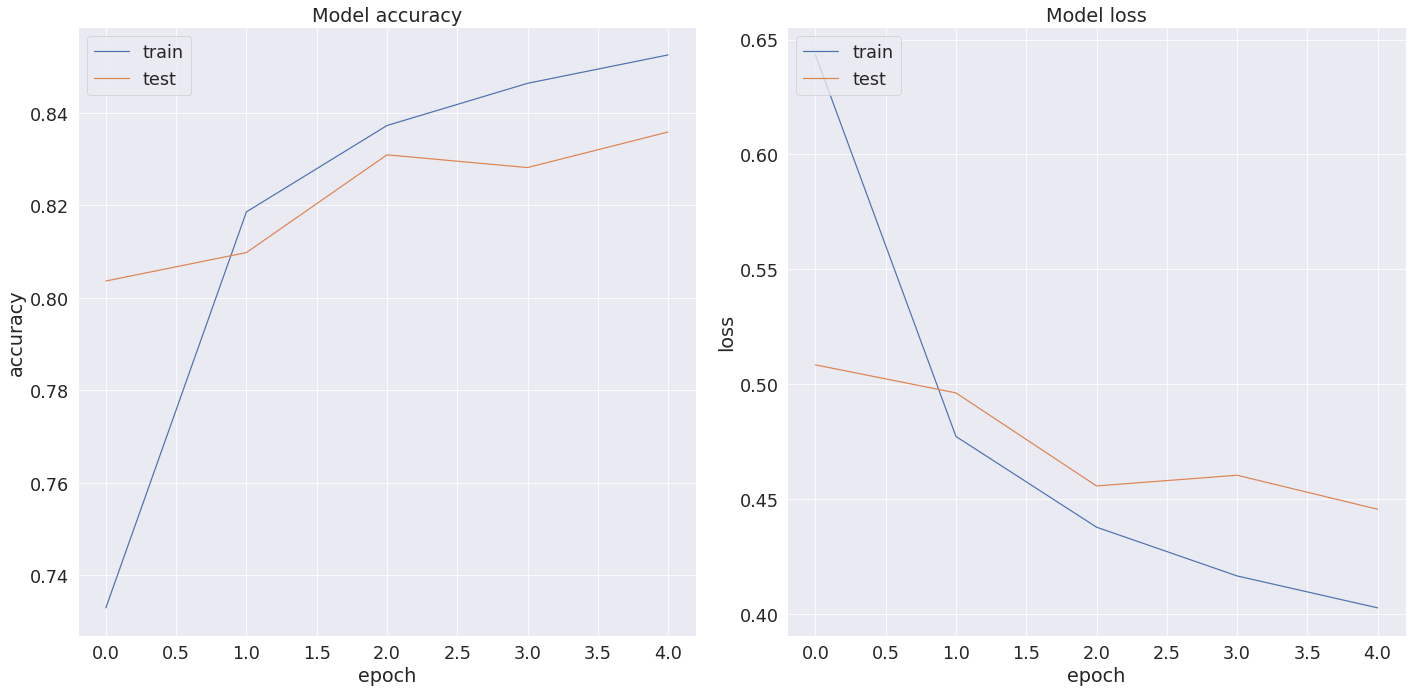

In [159]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [165]:
y_test_c = tf.keras.utils.to_categorical(
    df_test['Sentiment'].astype('category').cat.codes.values, num_classes=3)

e = classifier_model.evaluate(x=df_test['Tweet'].values, y=y_test_c)

119/119 [==============================] - 36s 303ms/step - loss: 0.4575 - accuracy: 0.8339


In [167]:
print(f"BERT Accuracy: {e[1]}")

BERT Accuracy: 0.833859920501709


In [174]:
y_proba_bert = classifier_model.predict(df_test['Tweet'].values)
y_pred_bert = np.argmax(y_proba_bert, axis=1)

<AxesSubplot:>

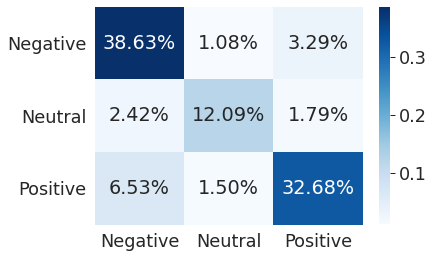

In [185]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred_bert)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [179]:
#Classification Report for BERT
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_true, y_pred_bert, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.81      0.90      0.85      1633
     Neutral       0.82      0.74      0.78       619
    Positive       0.87      0.80      0.83      1546

    accuracy                           0.83      3798
   macro avg       0.83      0.81      0.82      3798
weighted avg       0.84      0.83      0.83      3798



In [191]:
y_proba_cb = model.predict_proba(test_pool)

In [194]:
y_proba_avg = np.argmax((y_proba_cb + y_proba_bert)/2, axis=1)
print(f'Average accuracy: {accuracy_score(y_true, y_proba_avg)}')


Average accuracy: 0.855713533438652


<AxesSubplot:>

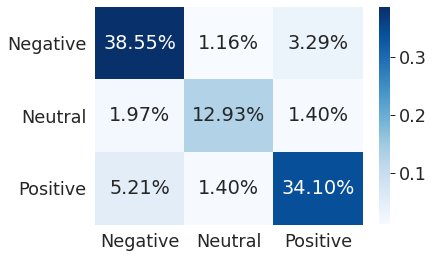

In [195]:
cf_matrix = confusion_matrix(y_true, y_proba_avg)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [196]:
print('\nClassification Report')
print(classification_report(y_true, y_proba_avg, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87      1633
     Neutral       0.84      0.79      0.81       619
    Positive       0.88      0.84      0.86      1546

    accuracy                           0.86      3798
   macro avg       0.85      0.84      0.85      3798
weighted avg       0.86      0.86      0.86      3798

